In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.special import gammainc

In [2]:
from src.hbtp.HBTReader import HBTReader
from src import read
from src import cosmology
from src import nfw
from src import einasto

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

### Analysis parameters

In [3]:
snap = 93
nbins = 20
bin = 8
r = HBTReader("./data/")

### Subhalo mass function

In [4]:
ss = r.LoadSubhalos(snap)
ss = ss[(ss['HostHaloId'] != -1) & (ss['BoundM200Crit'] > 0.0)& (ss['Nbound'] >= 20)]

counts, bin_edges = np.histogram(np.log10(ss['Nbound']), 20)
ss = np.lib.recfunctions.append_fields(ss, 'bin',\
    np.digitize(np.log10(ss['BoundM200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
print counts, bin_edges, bins

[31345 28611 23051 17130 11433  7403  4542  2878  1750  1082   628   394
   233   135    70    38    23    14     3     7] [ 1.30103     1.53069291  1.76035583  1.99001875  2.21968167  2.44934459
  2.67900751  2.90867042  3.13833334  3.36799626  3.59765918  3.8273221
  4.05698502  4.28664794  4.51631085  4.74597377  4.97563669  5.20529961
  5.43496253  5.66462545  5.89428836] [ 1.41586145  1.64552437  1.87518729  2.10485021  2.33451313  2.56417605
  2.79383897  3.02350188  3.2531648   3.48282772  3.71249064  3.94215356
  4.17181648  4.40147939  4.63114231  4.86080523  5.09046815  5.32013107
  5.54979399  5.77945691]


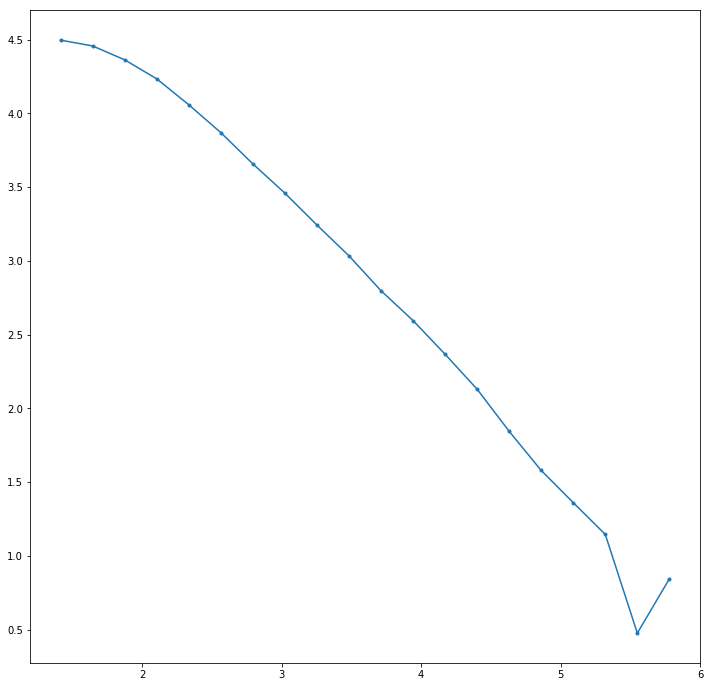

In [5]:
plt.plot(bins, np.log10(counts), color='C0', marker='.')

### Halo mass function

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [6]:
hs = r.LoadHostHalos(snap)[['HaloId','R200CritComoving','M200Crit','CenterOffset']]
hs = hs[(hs['M200Crit'] >= 20) & (hs['CenterOffset'] >= 0.1)]
hs['M200Crit'] = 1e10*hs['M200Crit']

counts, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
hs = np.lib.recfunctions.append_fields(hs, 'bin',\
    np.digitize(np.log10(hs['M200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
print counts, bin_edges, bins

[559 400 341 230 161 153 101  87  61  37  39  25  11  13  11   4   4   1
   4   3] [ 11.3013382   11.44088578  11.58043337  11.71998096  11.85952854
  11.99907613  12.13862371  12.2781713   12.41771889  12.55726647
  12.69681406  12.83636165  12.97590923  13.11545682  13.25500441
  13.39455199  13.53409958  13.67364717  13.81319475  13.95274234
  14.09228992] [ 11.37111199  11.51065958  11.65020716  11.78975475  11.92930233
  12.06884992  12.20839751  12.34794509  12.48749268  12.62704027
  12.76658785  12.90613544  13.04568303  13.18523061  13.3247782
  13.46432579  13.60387337  13.74342096  13.88296854  14.02251613]


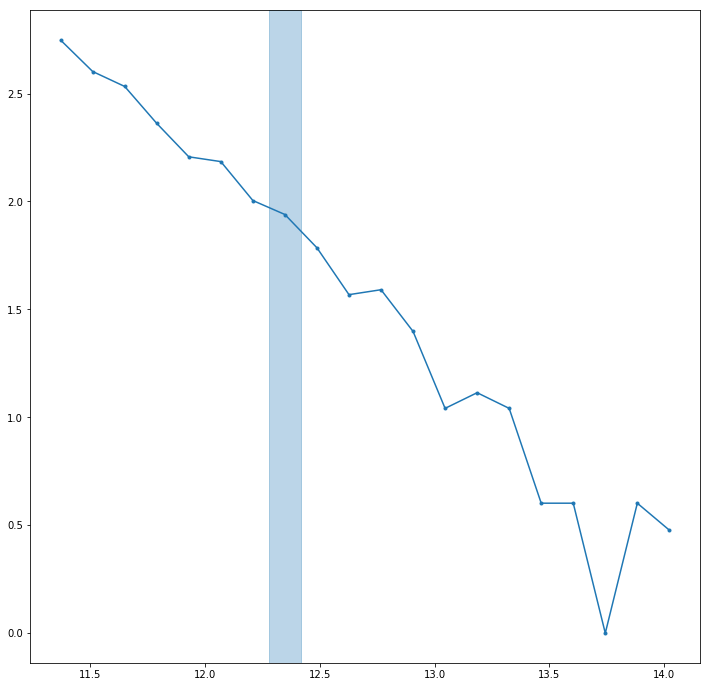

In [7]:
plt.plot(bins, np.log10(counts), color='C0', marker='.')
plt.axvspan(bin_edges[bin-1], bin_edges[bin], color='C0', alpha=0.3)

### Concentration - mass relation

In [8]:
hs = hs[hs['bin'] == bin]

### Density profile

In [9]:
ps = np.array(r.LoadHostHalos(snap, [list(hs['HaloId']),])['Profile'],\
    dtype=np.float)
xmin = 0.5*np.cbrt((4.0*np.pi)/(3.0*np.sum(np.mean(ps, axis=0))))
particles = np.sum(ps, axis=1)
ps = np.divide(ps.T, np.sum(ps, axis=1)).T
p = np.median(ps, axis=0)
x = np.linspace(-2.0, 0.0, 20)
vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))

xmax = 0.8
idx = np.where((np.power(10,x) < xmax) & (np.power(10,x) > xmin))

c, a, chi2 = einasto.fit(p, lambda c, a: einasto.m(np.power(10.0, x), c, a),\
    np.linspace(1.0, 10.0, 100), np.linspace(0.01, 0.99, 100))
rho_s = np.log10(einasto.rho_enc(1.0/c, c, a))

# c_nfw, chi2_nfw = nfw.fit(p, lambda c: nfw.m(np.power(10.0, x), c),\
#     np.linspace(1.0, 10.0, 100))
# rho_s_nfw = np.log10(nfw.rho_enc(1.0/c, c))

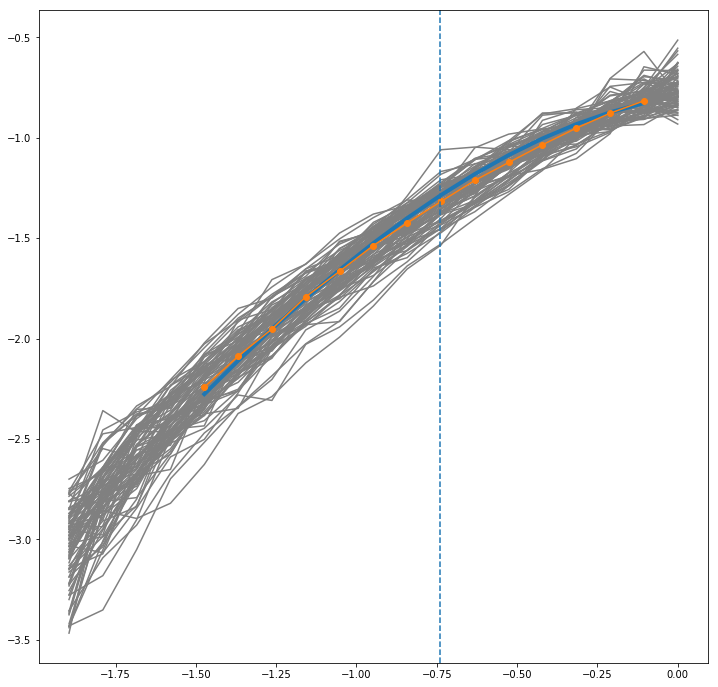

In [10]:
plt.plot(x[idx], np.log10(einasto.m(np.power(10.,x), c, a)[idx]),\
    color='C0', linewidth=4, zorder=1)

[plt.plot(x[1:], np.log10(_[1:]), color='grey', zorder=0) for _ in ps]
plt.plot(x[idx], np.log10(p[idx]), color='C1', marker='o', zorder=2)
plt.axvline(np.log10(1.0/c), color='C0', linestyle='--')

### Collapsed Mass History

In [11]:
F = einasto.m_enc(1.0/c, c, a)
print F

0.192013656764


In [12]:
ms = np.array(read.cmh(snap).loc[hs['HaloId']], dtype=np.float)
ms = np.divide(ms.T, ms[:,-1]).T
m = np.mean(ms, axis=0)

zs = read.snaps()
# np.genfromtxt('./output/hbtp/redshift_list.txt',\
#     dtype=np.dtype([('snapshot',np.int32), ('redshift',np.float32)]))
rho = cosmology.rho_c(\
    np.array([zs[zs['Snapshot'] == s][0]['Redshift']\
    for s in np.arange(1+snap-ms.shape[1], 1+snap)]))\
    / cosmology.rho_c(zs[zs['Snapshot'] == snap][0]['Redshift'])

In [13]:
m_f = F*m[-1]
y1, y2 = m[m > m_f][0], m[m < m_f][-1]
x1, x2 = rho[m > m_f][0], rho[m < m_f][-1]
rho_f = (np.log10(x1/x2)/np.log10(y1/y2))*(np.log10(m_f/y1))+np.log10(x1)

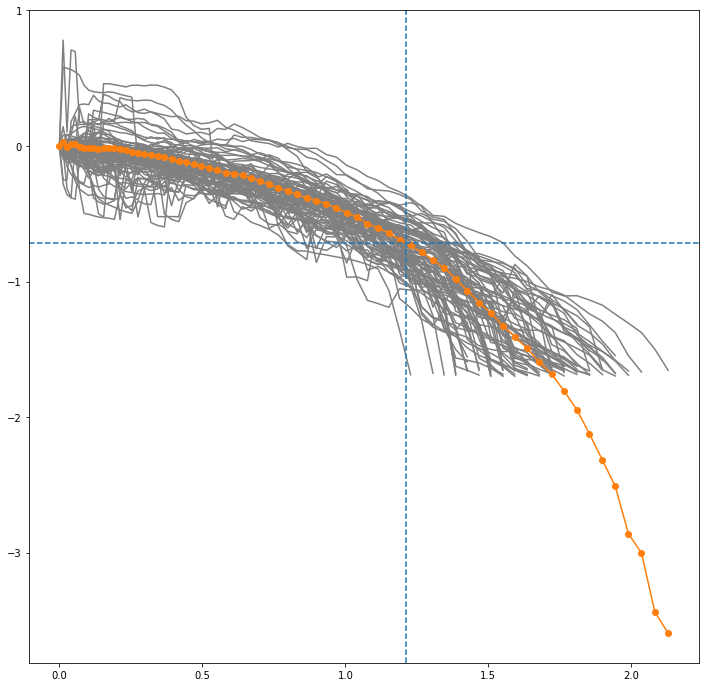

In [14]:
[plt.plot(np.log10(rho), np.log10(_), color='grey') for _ in ms]
plt.plot(np.log10(rho), np.log10(m),\
    color='C1', marker='o')
plt.axhline(np.log10(m_f), color='C0', linestyle='--')
plt.axvline(rho_f, color='C0', linestyle='--')

### Density - density relation

After the analysis above has been done for all mass bins, for all snapshots, we can start plotting the density - density relation.

In [15]:
rho_f, rho_s

(1.2134816386343887, 3.8022450557310643)

In [16]:
def plot(ax, ds):
    ax.plot([0.0, 3.0], np.log10(400.0 * np.power(10.0, np.array([0.0, 3.0]))), 'k-')

    markers = [['o', None], ['s', None], ['^', None], ['*', None], ['x', None]]
    colours = [['C0', None], ['C1', None]]

    for i,snap in enumerate(np.unique(ds['snap'])):
        for j,g in enumerate(np.unique(ds['g'])):
            for _, row in ds[(ds['snap'] == snap) & (ds['g'] == g)].iterrows():
                ax.scatter(
                    row['rho_f'], row['rho_s'],
                    color=colours[j][0],
                    marker=markers[i][0],
                    s=row['bin']*30,
                    alpha=0.6
                )
                markers[i][1] = plt.Line2D([], [], label='snap %d'%snap,
                    color='k', marker=markers[i][0], linestyle='')
            colours[j][1] = plt.Line2D([], [], label=g,
                color=colours[j][0], marker='o', linestyle='')

    ax.set_xlabel(r'$\log_{10}(\rho_{crit}(z_{form})/\rho_{crit}(z_0))$')
    ax.set_ylabel(r'$\log_{10}(\langle\rho_{s}\rangle/\rho_{crit}(z_0))$')
    ax.set_xlim((0.0, 2.0))
    ax.set_ylim((2.0, 5.0))

    l1 = ax.legend(handles=[markers[i][1] for i in range(len(markers))], loc='upper left')
    l2 = ax.legend(handles=[colours[j][1] for j in range(len(colours))], loc='lower right')
    ax.add_artist(l1)

In [17]:
def read():
    ds = pd.DataFrame()

    for g in ['gr', 'fr']:
        for p in ['nfw', 'einasto']:
            _ = pd.read_csv('/gpfs/data/dc-oles1/merger_trees/output/%s/%s.csv' % (g, p))
            _['g'] = g
            ds = pd.concat([ds, _])

    ds = ds.reset_index()
    del ds['index']
    
    return ds

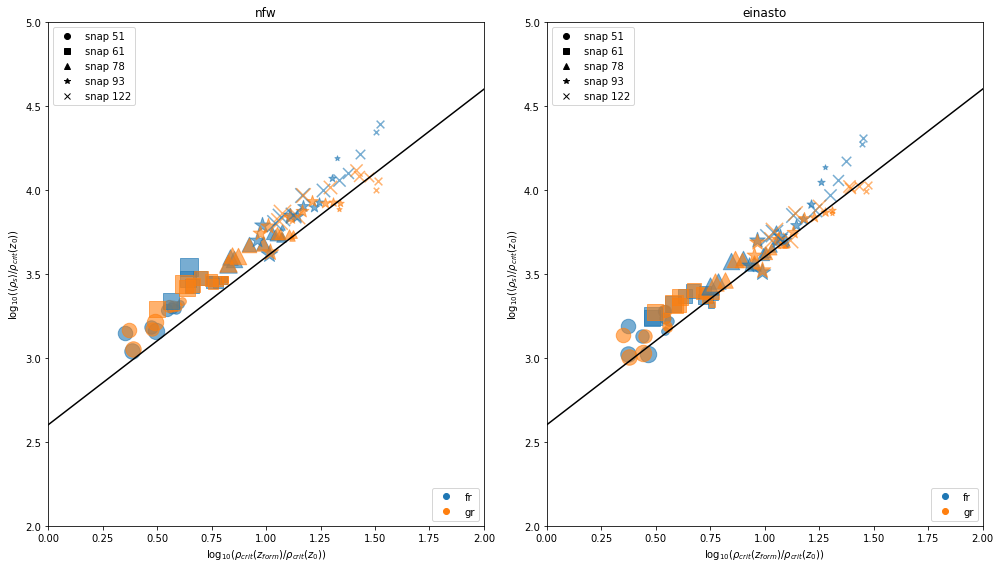

In [18]:
d = read()

fig, ax = plt.subplots(1, 2, figsize=(14, 8))

for i,p in enumerate(['nfw', 'einasto']):
    plot(ax[i], d[d['profile'] == p])
    ax[i].set_title(p)

fig.tight_layout()